## Single-cancer holdout dimension reduction analysis

Words go here.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
# load gene expression and mutation data
from pancancer_evaluation.data_models.tcga_data_model import TCGADataModel

tcga_data = TCGADataModel(seed=cfg.default_seed,
                          subset_mad_genes=cfg.num_features_raw,
                          verbose=True,
                          debug=False)

Loading gene expression data...
Loading sample info...
Loading pan-cancer data from cached pickle file...


In [3]:
# for a given gene and holdout percentage, generate reduced dimensional
# representation of train/test data
from sklearn.decomposition import PCA
from umap import UMAP

from pancancer_evaluation.utilities import data_utilities as du
from pancancer_evaluation.utilities import tcga_utilities as tu

pca = PCA(n_components=2)
umap = UMAP(n_components=2)

def generate_rep_holdout(gene, cancer_type, percent_holdout,
                         method='pca'):
    identifier = '{}_{}'.format(gene, cancer_type)
    classification = du.get_classification(gene)
    tcga_data.process_data_for_identifiers(identifier,
                                           identifier,
                                           classification,
                                           classification,
                                           output_dir=None,
                                           shuffle_labels=False,
                                           percent_holdout=percent_holdout,
                                           holdout_class='both')
    # this step standardizes columns and filters features by MAD
    X_train, X_test = tu.preprocess_data(tcga_data.X_train_raw_df,
                                         tcga_data.X_test_raw_df,
                                         tcga_data.gene_features,
                                         tcga_data.subset_mad_genes)
    # now take PCA and return 2-dimensional representation
    if method == 'pca':
        train_rep = pca.fit_transform(X_train)
        test_rep = pca.fit_transform(X_test)
    elif method == 'umap':
        train_rep = umap.fit_transform(X_train)
        test_rep = umap.fit_transform(X_test)
    # also return corresponding mutation labels
    train_labels = tcga_data.y_train_df.status.values
    test_labels = tcga_data.y_test_df.status.values
    return (train_rep, test_rep, train_labels, test_labels)

X, _, __, ___ = generate_rep_holdout('TP53', 'GBM', 0.5)
print(X.shape)
print(X[:5, :])

(62, 2)
[[-24.86078919 -19.84701966]
 [-71.78214107 -14.96675691]
 [ 14.85002665  73.82339542]
 [  4.25661987  46.87962647]
 [-98.60069106 -36.12117675]]


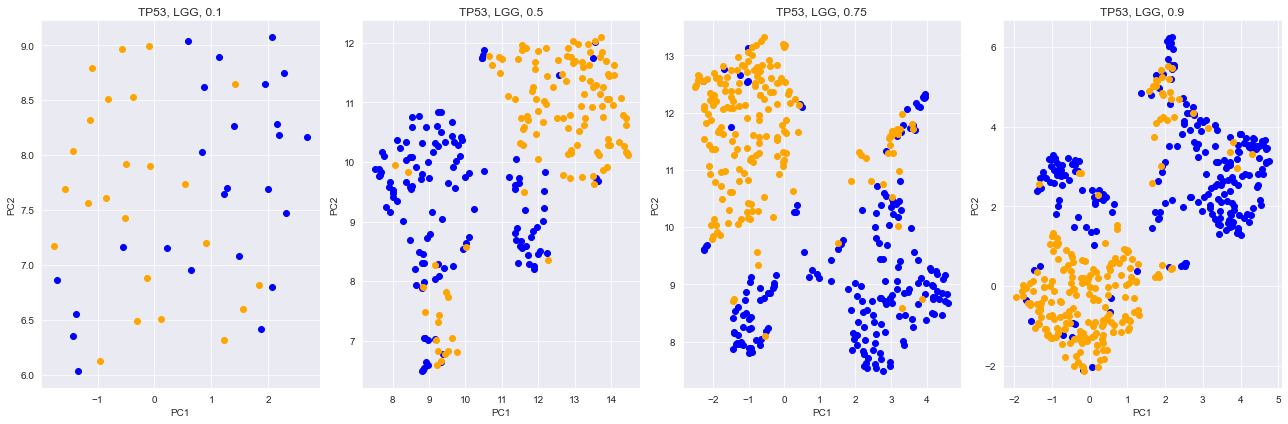

In [6]:
gene = 'TP53'
cancer_type = 'LGG'
remove_percents = [0.1, 0.5, 0.75, 0.9]
sns.set({'figure.figsize': (18, 6)})

fig, axarr = plt.subplots(1, len(remove_percents))

for ix, remove_percent in enumerate(remove_percents):
    ax = axarr[ix]
    _, X_transform, __, y_transform = generate_rep_holdout(gene, cancer_type, remove_percent,
                                                           method='umap')
    ax.scatter(x=X_transform[y_transform == 0, 0], y=X_transform[y_transform == 0, 1], color='blue')
    ax.scatter(x=X_transform[y_transform == 1, 0], y=X_transform[y_transform == 1, 1], color='orange')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('{}, {}, {}'.format(gene, cancer_type, remove_percent))
plt.tight_layout()

In [9]:
# reproduce the line plot from plot_holdout_single_cancer, but only for one gene
# this will put the above plots in context
results_dir = os.path.join(cfg.results_dir,
                           'cross_cancer',
                           'cross_cancer_flip_counts',
                           'cross_cancer_flip_labels')
flip_labels_df = (
    au.load_flip_labels_results(results_dir, 'flip_labels')
      .sort_values(by=['train_identifier', 'test_identifier',
                       'percent_flip', 'signal'])
)

flip_norm_df = au.normalize_to_control(flip_labels_df,
                                       train_id='train_identifier',
                                       test_id='test_identifier',
                                       additional_cols=['percent_flip'])
flip_norm_df = (
    flip_norm_df.assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                        cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
                .drop(columns=['train_identifier', 'test_identifier'])
                .reset_index(drop=True)
)
flip_norm_df['identifier'] = flip_norm_df.gene + '_' + flip_norm_df.cancer_type
flip_norm_df.head()

,percent_flip,aupr,gene,cancer_type,identifier
0,0.10,0.61445,TP53,GBM,TP53_GBM
1,0.10,0.42826,EGFR,LGG,EGFR_LGG
2,0.90,0.03904,TP53,PAAD,TP53_PAAD
3,0.95,0.46171,TP53,BRCA,TP53_BRCA
4,0.50,0.55765,TP53,BRCA,TP53_BRCA


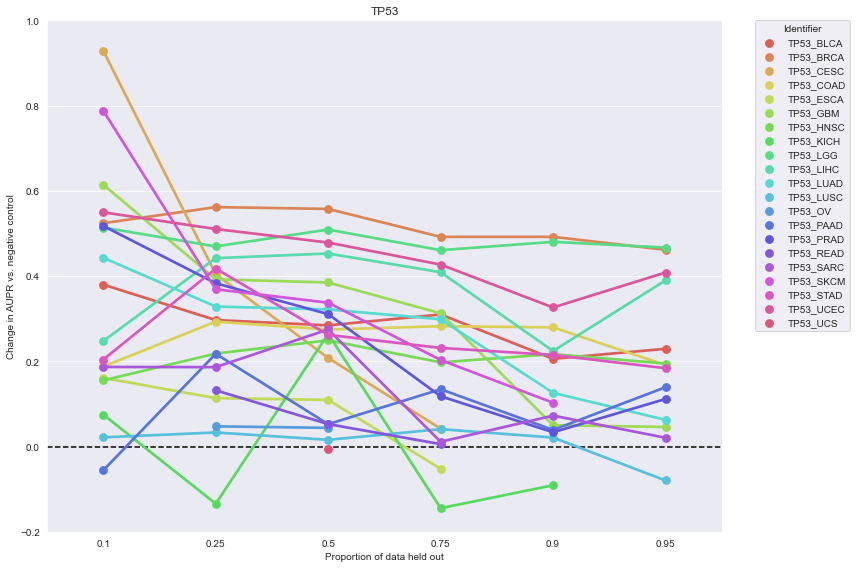

In [26]:
sns.set({'figure.figsize': (12, 8)})
plot_df = (
    flip_norm_df[(flip_norm_df.gene == gene)].sort_values(by='cancer_type')
)
g = sns.pointplot(data=plot_df, x='percent_flip', y='aupr', hue='identifier',
                  palette='hls')
plt.xlabel('Proportion of data held out')
plt.ylabel('Change in AUPR vs. negative control')
plt.ylim(-0.2, 1.0)
plt.title(gene)
plt.legend(title='Identifier', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y=0, color='black', linestyle='--')
plt.tight_layout()